In [2]:
import json, random, argparse, pathlib, numpy as np
from tqdm import tqdm
from collections import defaultdict
from dataclasses import dataclass
from typing import List, Dict

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW

from transformers import (
    AutoTokenizer,
    AutoModelForTokenClassification,
    get_linear_schedule_with_warmup,
    DistilBertForTokenClassification, AlbertForTokenClassification,
    DistilBertTokenizerFast
)

import wandb
import auxiliary as aux

all_labels = [
    'B-STREET', 'B-CITY', 'I-DATE', 'B-PASS', 'I-CITY', 'B-TIME', 'B-EMAIL', 'I-DRIVERLICENSE',
    'I-POSTCODE', 'I-BOD', 'B-USERNAME', 'B-BOD', 'B-COUNTRY', 'B-SECADDRESS', 'B-IDCARD',
    'I-SOCIALNUMBER', 'I-PASSPORT', 'B-IP', 'O', 'B-TEL', 'B-SOCIALNUMBER', 'I-TIME', 'B-BUILDING',
    'B-PASSPORT', 'I-TITLE', 'I-SEX', 'I-STREET', 'B-STATE', 'I-STATE', 'B-TITLE', 'B-DATE',
    'B-GEOCOORD', 'I-IDCARD', 'I-TEL', 'B-POSTCODE', 'B-DRIVERLICENSE', 'I-GEOCOORD',
    'I-COUNTRY', 'I-EMAIL', 'I-PASS', 'B-SEX', 'I-USERNAME', 'I-BUILDING', 'I-IP',
    'I-SECADDRESS', 'B-CARDISSUER', 'I-CARDISSUER'
]

id2label = {i: l for i, l in enumerate(all_labels)}
label2id = {v: k for k, v in id2label.items()}
n_labels = len(all_labels)

distil_tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
albert_tokenizer = AutoTokenizer.from_pretrained("albert-base-v2")

In [3]:
# Define a custom collate function to pad batched sequences
def collate_batch(batch):
    # Determine max lengths for padding
    max_len_distil = max(len(item["distilbert_inputids"]) for item in batch)
    max_len_albert = max(len(item["albert_inputids"]) for item in batch)
    max_len_words  = max(len(item["spacy_labels"]) for item in batch)
    # Pad input_ids and attention_mask for distil and albert
    input_ids_distil_batch, attention_mask_distil_batch = [], []
    input_ids_albert_batch, attention_mask_albert_batch = [], []
    labels_distil_batch, labels_albert_batch = [], []
    word_ids_distil_batch, word_ids_albert_batch = [], []
    word_labels_batch = []
    for item in batch:
        # Pad DistilBERT inputs
        ids = item["distilbert_inputids"] + [distil_tokenizer.pad_token_id] * (max_len_distil - len(item["distilbert_inputids"]))
        mask = item["distilbert_attention_masks"] + [0] * (max_len_distil - len(item["distilbert_attention_masks"]))
        labels_d = item["distilbert_token_labels"] + [-100] * (max_len_distil - len(item["distilbert_token_labels"]))
        # Pad ALBERT inputs
        ids_a = item["albert_inputids"] + [albert_tokenizer.pad_token_id] * (max_len_albert - len(item["albert_inputids"]))
        mask_a = item["albert_attention_masks"] + [0] * (max_len_albert - len(item["albert_attention_masks"]))
        labels_a = item["albert_token_labels"] + [-100] * (max_len_albert - len(item["albert_token_labels"]))
        # Pad word_ids mapping (use -1 for padding positions for clarity)
        word_ids_d = item["distilbert_wordids"] + [None] * (max_len_distil - len(item["distilbert_wordids"]))
        word_ids_a = item["albert_wordids"] + [None] * (max_len_albert - len(item["albert_wordids"]))
        # Pad word-level labels
        w_labels = item["spacy_labels"] + [-100] * (max_len_words - len(item["spacy_labels"]))
        # Collect padded items
        input_ids_distil_batch.append(torch.tensor(ids))
        attention_mask_distil_batch.append(torch.tensor(mask))
        labels_distil_batch.append(torch.tensor(labels_d))
        word_ids_distil_batch.append(word_ids_d)  # keep as list of None/idx (non-tensor for now)
        input_ids_albert_batch.append(torch.tensor(ids_a))
        attention_mask_albert_batch.append(torch.tensor(mask_a))
        labels_albert_batch.append(torch.tensor(labels_a))
        word_ids_albert_batch.append(word_ids_a)
        word_labels_batch.append(torch.tensor(w_labels))
    # Stack all batches
    batch_tensors = {
        "distilbert_inputids": torch.stack(input_ids_distil_batch),
        "distilbert_attention_masks": torch.stack(attention_mask_distil_batch),
        "distilbert_token_labels": torch.stack(labels_distil_batch),
        "distilbert_wordids": word_ids_distil_batch,  # list of lists (will be used in model forward)
        "albert_inputids": torch.stack(input_ids_albert_batch),
        "albert_attention_masks": torch.stack(attention_mask_albert_batch),
        "albert_token_labels": torch.stack(labels_albert_batch),
        "albert_wordids": word_ids_albert_batch,
        "spacy_labels": torch.stack(word_labels_batch)
    }
    return batch_tensors


In [51]:
train_encodings = aux.json_to_Dataset_ensemble("datasets/ensemble_train.json")
bs = 4

In [70]:
distilbert = DistilBertForTokenClassification.from_pretrained("models/distilbert1", num_labels=len(all_labels), label2id=label2id, id2label=id2label)
albert = AlbertForTokenClassification.from_pretrained("models/albert1", num_labels=len(all_labels), label2id=label2id, id2label=id2label)

In [ ]:
input_ids_distil = train_encodings[0:bs]["distilbert_inputids"]
input_ids_albert = train_encodings[0:bs]["albert_inputids"]
attention_mask_distil = train_encodings[0:bs]["distilbert_attention_masks"]
attention_mask_albert = train_encodings[0:bs]["albert_attention_masks"]
distil_word_ids = train_encodings[0:bs]["distilbert_wordids"]
albert_word_ids = train_encodings[0:bs]["albert_wordids"]
labels = train_encodings[0:bs]["spacy_labels"]


In [142]:
train_loader = DataLoader(train_encodings, batch_size=4, shuffle=False, collate_fn=collate_batch)
for batch in train_loader:
    # distilbert(input_ids=input_ids_distil, attention_mask=attention_mask_distil)
    input_ids_distil = batch["distilbert_inputids"]
    input_ids_albert = batch["albert_inputids"]
    attention_mask_distil = batch["distilbert_attention_masks"]
    attention_mask_albert = batch["albert_attention_masks"]
    distil_word_ids = batch["distilbert_wordids"]
    albert_word_ids = batch["albert_wordids"]
    labels = batch["spacy_labels"]
    
    distil_outputs = distilbert(input_ids=input_ids_distil, attention_mask=attention_mask_distil)
    albert_outputs = albert(input_ids=input_ids_albert, attention_mask=attention_mask_albert)

    logits_distil = distil_outputs.logits
    logits_albert = albert_outputs.logits
    max_words = labels.size(1)

    print(max_words)
    print("batch 0: ", max([i for i in distil_word_ids[0] if i is not None]))
    print("batch 0: ", max([i for i in albert_word_ids[0] if i is not None]))
    print("batch 1: ", max([i for i in distil_word_ids[1] if i is not None]))
    print("batch 1: ", max([i for i in albert_word_ids[1] if i is not None]))
    print("batch 2: ", max([i for i in distil_word_ids[2] if i is not None]))
    print("batch 2: ", max([i for i in albert_word_ids[2] if i is not None]))
    print("batch 3: ", max([i for i in distil_word_ids[3] if i is not None]))
    print("batch 3: ", max([i for i in albert_word_ids[3] if i is not None]))
    print()
    print("batch 0: ", len(set([i for i in distil_word_ids[0] if i is not None])))
    print("batch 0: ", len(set([i for i in albert_word_ids[0] if i is not None])))
    print("batch 1: ", len(set([i for i in distil_word_ids[1] if i is not None])))
    print("batch 1: ", len(set([i for i in albert_word_ids[1] if i is not None])))
    print("batch 2: ", len(set([i for i in distil_word_ids[2] if i is not None])))
    print("batch 2: ", len(set([i for i in albert_word_ids[2] if i is not None])))
    print("batch 3: ", len(set([i for i in distil_word_ids[3] if i is not None])))
    print("batch 3: ", len(set([i for i in albert_word_ids[3] if i is not None])))
    print(logits_distil[0].shape)
    print(logits_albert[0].shape)
    
    # for i in range(4):
    #     print("logits_albert:", logits_albert[0][i])
    
    combined_logits = torch.zeros((bs, max_words, n_labels))

    for b in range(bs):
        distil_map = distil_word_ids[b]  # list of length seq_len_distil
        albert_map = albert_word_ids[b]  # list of length seq_len_albert

        print("distil_map:", distil_map)
        print("albert_map:", albert_map)

        count = 0
        for token_index, word_index in enumerate(distil_map):

            # if count == 2:
            #     break
            # count += 1

            if word_index is None:
                continue  # skip special tokens ([CLS], [SEP], etc.)
            # Take the first subtoken of each word for DistilBERT
            # (Only the first subtoken carries the label, others should be ignored)
            if token_index > 0 and distil_map[token_index] == distil_map[token_index-1]:
                # Skip subtokens that map to the same word as a previous token
                continue
            # Find the corresponding first subtoken from ALBERT mapping for the same word
            # We locate the first occurrence of this word index in ALBERT's token map
            try:
                albert_token_index = albert_map.index(word_index)
            except ValueError:
                # If the word index is not found in ALBERT's tokens (e.g., ALBERT truncated earlier),
                # skip averaging for this word.
                continue
            # Compute average of logits from both models for this word position
            combined_logits[b, word_index, :] = (logits_distil[b, token_index, :] + logits_albert[b, albert_token_index, :]) / 2.0
        
        for i in range(4):
            print(len(combined_logits[i]))
            print(len(labels[i]))

        
            
        break
    break

130
batch 0:  84
batch 0:  84
batch 1:  72
batch 1:  72
batch 2:  74
batch 2:  74
batch 3:  129
batch 3:  129

batch 0:  79
batch 0:  79
batch 1:  65
batch 1:  65
batch 2:  60
batch 2:  60
batch 3:  112
batch 3:  112
torch.Size([140, 47])
torch.Size([222, 47])
distil_map: [None, 0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 69, 70, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 71, 73, 74, 75, 76, 76, 76, 76, 76, 76, 76, 78, 78, 79, 80, 81, 82, 84, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
albert_map: [None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 8, 10, 11, 12, 12, 14, 15, 16, 17, 18, 19, 20, 2

In [7]:
class CubeBert(nn.Module):
    def __init__(self, distilbert_model="distilbert-base-uncased", albert_model="albert-base-v2", freeze_backbones=True):
        super(CubeBert, self).__init__()
        self.distilbert = DistilBertForTokenClassification.from_pretrained(
            distilbert_model, num_labels=len(all_labels), label2id=label2id, id2label=id2label
        )
        self.albert = AlbertForTokenClassification.from_pretrained(
            albert_model, num_labels=len(all_labels), label2id=label2id, id2label=id2label
        )

        if freeze_backbones:
            for param in self.distilbert.parameters():
                param.requires_grad = False
            for param in self.albert.parameters():
                param.requires_grad = False

        # Trainable fusion weights (one per class), initialized to 0.5 (sigmoid(0) = 0.5)
        self.alpha_logits = nn.Parameter(torch.zeros(len(all_labels)))  # logits before sigmoid

    def forward(self,
                input_ids_distil, attention_mask_distil,
                input_ids_albert, attention_mask_albert,
                distil_word_ids=None, albert_word_ids=None,
                labels=None):
        
        distil_outputs = self.distilbert(input_ids=input_ids_distil, attention_mask=attention_mask_distil)
        albert_outputs = self.albert(input_ids=input_ids_albert, attention_mask=attention_mask_albert)

        logits_distil = distil_outputs.logits
        logits_albert = albert_outputs.logits

        # α ∈ (0,1) for each class
        alpha = torch.sigmoid(self.alpha_logits)  # shape: [num_labels]
        alpha = alpha.view(1, 1, -1)  # broadcast to [batch_size, seq_len, num_labels]

        batch_size = logits_distil.size(0)
        num_labels = logits_distil.size(-1)

        if labels is not None:
            max_words = labels.size(1)
        else:
            max_words = max([
                max((wi for wi in d if wi is not None), default=0)
                for d in distil_word_ids
            ]) + 1

        device = logits_distil.device
        combined_logits = torch.zeros((batch_size, max_words, num_labels), device=device)

        for b in range(batch_size):
            distil_map = distil_word_ids[b]
            albert_map = albert_word_ids[b]

            for token_index, word_index in enumerate(distil_map):
                if word_index is None or (token_index > 0 and distil_map[token_index] == distil_map[token_index - 1]):
                    continue
                try:
                    albert_token_index = albert_map.index(word_index)
                except ValueError:
                    continue

                # Weighted average: α * distil + (1-α) * albert (per class)
                logits_d = logits_distil[b, token_index]
                logits_a = logits_albert[b, albert_token_index]
                fused = alpha * logits_d + (1 - alpha) * logits_a
                combined_logits[b, word_index] = fused

        loss = None
        if labels is not None:
            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            loss = loss_fn(combined_logits.view(-1, num_labels), labels.view(-1))

        return {"logits": combined_logits, "loss": loss} if loss is not None else {"logits": combined_logits}


In [4]:
class CubeBertEnsemble(nn.Module):
    def __init__(self, distilbert_model="distilbert-base-uncased", albert_model="albert-base-v2"):
        super(CubeBertEnsemble, self).__init__()
        # Load DistilBERT and ALBERT for token classification (num_labels based on PII label set)
        self.distilbert = DistilBertForTokenClassification.from_pretrained(
            distilbert_model, num_labels=len(all_labels), label2id=label2id, id2label=id2label
        )
        self.albert = AlbertForTokenClassification.from_pretrained(
            albert_model, num_labels=len(all_labels), label2id=label2id, id2label=id2label
        )
    
    def forward(self, 
                input_ids_distil, attention_mask_distil, 
                input_ids_albert, attention_mask_albert, 
                distil_word_ids=None, albert_word_ids=None, 
                labels=None):
        # Get logits from DistilBERT model
        distil_outputs = self.distilbert(input_ids=input_ids_distil, attention_mask=attention_mask_distil)
        logits_distil = distil_outputs.logits  # shape: (batch_size, seq_len_distil, num_labels)
        # Get logits from ALBERT model
        albert_outputs = self.albert(input_ids=input_ids_albert, attention_mask=attention_mask_albert)
        logits_albert = albert_outputs.logits  # shape: (batch_size, seq_len_albert, num_labels)
        
        # Ensure we have word alignment info for each sequence in the batch
        # distil_word_ids and albert_word_ids are lists of length seq_len for each sequence (with None for special tokens).
        # We will use these to average logits at the original word positions.
        batch_size = logits_distil.size(0)
        num_labels = logits_distil.size(-1)
        # Determine number of original word tokens (if labels provided, use that length, otherwise infer from word_ids)
        if labels is not None:
            max_words = labels.size(1)  # labels shape (batch_size, seq_len_words)
        else:
            # Infer max word count from word_id mappings (max valid index + 1)
            max_words = 0
            for b in range(batch_size):
                # filter out None in word_ids and take max
                max_word_idx = max([wi for wi in distil_word_ids[b] if wi is not None] or [0,])
                if max_word_idx + 1 > max_words:
                    max_words = max_word_idx + 1
        
        # Initialize combined logits tensor (batch_size, max_words, num_labels)
        device = logits_distil.device
        combined_logits = torch.zeros((batch_size, max_words, num_labels), device=device)
        
        # Average logits from both models for each word index
        for b in range(batch_size):
            # Get mapping of token index -> word index for each model
            distil_map = distil_word_ids[b]  # list of length seq_len_distil
            albert_map = albert_word_ids[b]  # list of length seq_len_albert
            for token_index, word_index in enumerate(distil_map):
                if word_index is None:
                    continue  # skip special tokens ([CLS], [SEP], etc.)
                # Take the first subtoken of each word for DistilBERT
                # (Only the first subtoken carries the label, others should be ignored)
                if token_index > 0 and distil_map[token_index] == distil_map[token_index-1]:
                    # Skip subtokens that map to the same word as a previous token
                    continue
                # Find the corresponding first subtoken from ALBERT mapping for the same word
                # We locate the first occurrence of this word index in ALBERT's token map
                try:
                    albert_token_index = albert_map.index(word_index)
                except ValueError:
                    # If the word index is not found in ALBERT's tokens (e.g., ALBERT truncated earlier),
                    # skip averaging for this word.
                    continue
                # Compute average of logits from both models for this word position
                combined_logits[b, word_index, :] = (logits_distil[b, token_index, :] + logits_albert[b, albert_token_index, :]) / 2.0
        
        loss = None
        if labels is not None:
            # Compute loss on the combined logits using CrossEntropyLoss, ignoring positions with -100
            loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
            # Flatten tensors for loss computation
            loss = loss_fn(combined_logits.view(-1, num_labels), labels.view(-1))
        return {"logits": combined_logits, "loss": loss} if loss is not None else {"logits": combined_logits}


In [162]:
model = CubeBertEnsemble("models/distilbert1", "models/albert1")

train_loader = DataLoader(train_encodings, batch_size=4, shuffle=False, collate_fn=collate_batch)
for batch in train_loader:
    # print(batch["spacy_labels"])
    input_ids_distil = batch["distilbert_inputids"]
    attention_mask_distil = batch["distilbert_attention_masks"]
    input_ids_albert = batch["albert_inputids"]
    attention_mask_albert = batch["albert_attention_masks"]

    distil_word_ids = batch["distilbert_wordids"]
    albert_word_ids = batch["albert_wordids"]
    for j in range(4):
        print("batch 0: ", max([i for i in distil_word_ids[j] if i is not None]))
        print("batch 0: ", max([i for i in albert_word_ids[j] if i is not None]))


    # We use the model without passing labels to get predictions
    with torch.no_grad():
        outputs = model(input_ids_distil=input_ids_distil,
                        attention_mask_distil=attention_mask_distil,
                        input_ids_albert=input_ids_albert,
                        attention_mask_albert=attention_mask_albert,
                        distil_word_ids=batch["distilbert_wordids"],
                        albert_word_ids=batch["albert_wordids"])
        
    logits = outputs["logits"]
    print(logits.shape)
    pred_ids = logits.argmax(dim=-1).cpu().numpy()  # shape: (batch_size, seq_len_words)
    true_ids = batch["spacy_labels"].cpu().numpy()

    print(pred_ids.shape)
    print(true_ids.shape)

    for i in range(len(pred_ids)):
        pred_seq = []
        true_seq = []
        for j in range(len(true_ids[i])):
            if true_ids[i][j] == -100:
                # Skip padded positions (no actual token)
                continue
            true_label_id = int(true_ids[i][j])
            pred_label_id = int(pred_ids[i][j])
            # Map IDs to label strings using id2label
            true_seq.append(id2label[true_label_id])
            pred_seq.append(id2label[pred_label_id])
        
        print(len(pred_seq))
        print("pred_seq:", pred_seq)
        print(len(true_seq))
        print("true_seq:", true_seq)
        break
    break

batch 0:  84
batch 0:  84
batch 0:  72
batch 0:  72
batch 0:  74
batch 0:  74
batch 0:  129
batch 0:  129
torch.Size([4, 130, 47])
(4, 130)
(4, 130)
85
pred_seq: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STREET', 'O', 'O', 'O', 'B-STREET', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-STREET', 'O', 'O', 'O', 'O', 'B-USERNAME', 'B-STREET', 'O', 'O', 'O', 'B-IDCARD', 'B-STREET', 'O', 'O', 'O', 'B-TIME', 'I-TIME', 'B-STREET', 'O']
85
true_seq: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 

In [5]:
from seqeval.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def evaluate_model(model, data_loader, device):
    model.to(device).eval()  # set model to evaluation mode
    all_true_labels = []
    all_pred_labels = []
    for batch in tqdm(data_loader):
        # Move inputs to device
        input_ids_distil = batch["distilbert_inputids"].to(device)
        attention_mask_distil = batch["distilbert_attention_masks"].to(device)
        input_ids_albert = batch["albert_inputids"].to(device)
        attention_mask_albert = batch["albert_attention_masks"].to(device)
        # We use the model without passing labels to get predictions
        with torch.no_grad():
            outputs = model(input_ids_distil=input_ids_distil,
                            attention_mask_distil=attention_mask_distil,
                            input_ids_albert=input_ids_albert,
                            attention_mask_albert=attention_mask_albert,
                            distil_word_ids=batch["distilbert_wordids"],
                            albert_word_ids=batch["albert_wordids"])
        logits = outputs["logits"]  # shape: (batch_size, seq_len_words, num_labels)
        # Get predicted label IDs (highest logit) for each word
        pred_ids = logits.argmax(dim=-1).cpu().numpy()  # shape: (batch_size, seq_len_words)
        true_ids = batch["spacy_labels"].cpu().numpy()   # true label IDs with -100 for padding
        # Convert IDs to label names, ignoring any padding (-100)
        for i in range(len(pred_ids)):
            pred_seq = []
            true_seq = []
            for j in range(len(true_ids[i])):
                if true_ids[i][j] == -100:
                    # Skip padded positions (no actual token)
                    continue
                true_label_id = int(true_ids[i][j])
                pred_label_id = int(pred_ids[i][j])
                # Map IDs to label strings using id2label
                true_seq.append(id2label[true_label_id])
                pred_seq.append(id2label[pred_label_id])
            all_true_labels.append(true_seq)
            all_pred_labels.append(pred_seq)
    # Compute metrics using seqeval
    precision = precision_score(all_true_labels, all_pred_labels)
    recall = recall_score(all_true_labels, all_pred_labels)
    f1 = f1_score(all_true_labels, all_pred_labels)
    accuracy = accuracy_score(all_true_labels, all_pred_labels)
    # You can also print a detailed classification report per entity type if needed:
    # from seqeval.metrics import classification_report
    print(classification_report(all_true_labels, all_pred_labels))


    flat_preds = [label for seq in all_pred_labels for label in seq]
    flat_labels = [label for seq in all_true_labels for label in seq]

    flat_preds_encoded = [label2id[label] for label in flat_preds]
    flat_labels_encoded = [label2id[label] for label in flat_labels]


    conf_mat = confusion_matrix(flat_labels_encoded, flat_preds_encoded, labels=range(len(all_labels)))

    disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat, display_labels=all_labels)
    disp.plot(xticks_rotation='vertical', values_format='d', cmap='Blues')
    plt.show()

    model.train()  # switch back to training mode
    return {"precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy}


100%|██████████| 66/66 [00:57<00:00,  1.15it/s]


               precision    recall  f1-score   support

          BOD       0.98      0.98      0.98       460
     BUILDING       0.99      0.99      0.99       471
         CITY       0.96      0.99      0.98       493
      COUNTRY       0.96      0.98      0.97       343
         DATE       0.92      0.95      0.94       423
DRIVERLICENSE       0.95      0.90      0.93       572
        EMAIL       0.99      0.99      0.99       660
     GEOCOORD       0.98      1.00      0.99        57
       IDCARD       0.92      0.91      0.91       670
           IP       1.00      0.99      0.99       503
         PASS       0.96      0.96      0.96       300
     PASSPORT       0.89      0.94      0.91       587
     POSTCODE       0.98      0.99      0.98       458
   SECADDRESS       0.97      0.97      0.97       210
          SEX       0.96      1.00      0.98       455
 SOCIALNUMBER       0.94      0.95      0.94       660
        STATE       0.98      0.99      0.99       505
       ST

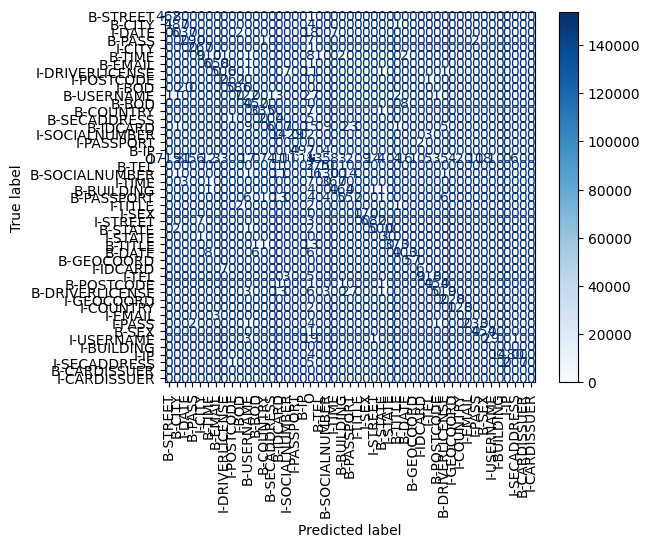

{'precision': np.float64(0.3710732282620349),
 'recall': np.float64(0.9651422197434467),
 'f1': np.float64(0.5360489429257337),
 'accuracy': 0.9057800183125125}

In [ ]:
train_encodings = aux.json_to_Dataset_ensemble("datasets/ensemble_train.json")
val_encodings = aux.json_to_Dataset_ensemble("datasets/ensemble_val.json")


model = CubeBert("models/distilbert1", "models/albert1", freeze_backbones=True)

train_loader = DataLoader(val_encodings, batch_size=32, shuffle=True, collate_fn=collate_batch)
evaluate_model(model, train_loader, 'cuda')

100it [00:44,  2.13it/s]

Epoch 1, step 100: loss = 0.4592


200it [01:30,  2.10it/s]

Epoch 1, step 200: loss = 0.3377


300it [02:16,  2.26it/s]

Epoch 1, step 300: loss = 0.3312


400it [03:07,  2.26it/s]

Epoch 1, step 400: loss = 0.3556


500it [04:02,  2.14it/s]

Epoch 1, step 500: loss = 0.3842


600it [04:47,  2.03it/s]

Epoch 1, step 600: loss = 0.2819


700it [05:33,  1.15s/it]

Epoch 1, step 700: loss = 0.2846


800it [06:19,  2.15it/s]

Epoch 1, step 800: loss = 0.3475


900it [07:04,  2.61it/s]

Epoch 1, step 900: loss = 0.4111


1000it [07:59,  2.15it/s]

Epoch 1, step 1000: loss = 0.3412


1100it [08:43,  2.51it/s]

Epoch 1, step 1100: loss = 0.4097


1200it [09:25,  2.48it/s]

Epoch 1, step 1200: loss = 0.3099


1300it [10:06,  2.09it/s]

Epoch 1, step 1300: loss = 0.4129


1400it [10:48,  2.00it/s]

Epoch 1, step 1400: loss = 0.2954


1500it [11:35,  2.16it/s]

Epoch 1, step 1500: loss = 0.2891


1600it [12:20,  2.28it/s]

Epoch 1, step 1600: loss = 0.5550


1700it [13:01,  2.34it/s]

Epoch 1, step 1700: loss = 0.2854


1800it [13:44,  2.41it/s]

Epoch 1, step 1800: loss = 0.2495


1900it [14:26,  2.59it/s]

Epoch 1, step 1900: loss = 0.3314


2000it [15:12,  2.22it/s]

Epoch 1, step 2000: loss = 0.2963


2100it [15:55,  2.27it/s]

Epoch 1, step 2100: loss = 0.1692


2200it [16:36,  2.32it/s]

Epoch 1, step 2200: loss = 0.3661


2300it [17:24,  1.35it/s]

Epoch 1, step 2300: loss = 0.2712


2332it [17:36,  2.21it/s]


Epoch 1 completed. Average training loss: 0.3687


100%|██████████| 66/66 [02:26<00:00,  2.22s/it]


               precision    recall  f1-score   support

          BOD       0.97      0.98      0.98       460
     BUILDING       0.98      0.99      0.98       471
         CITY       0.96      0.98      0.97       493
      COUNTRY       0.98      0.96      0.97       343
         DATE       0.91      0.92      0.91       423
DRIVERLICENSE       0.94      0.88      0.91       572
        EMAIL       0.99      0.99      0.99       660
     GEOCOORD       0.98      1.00      0.99        57
       IDCARD       0.90      0.92      0.91       670
           IP       0.97      0.99      0.98       503
         PASS       0.94      0.94      0.94       300
     PASSPORT       0.86      0.94      0.90       587
     POSTCODE       0.96      0.98      0.97       458
   SECADDRESS       0.98      0.97      0.98       210
          SEX       0.97      0.99      0.98       455
 SOCIALNUMBER       0.91      0.94      0.92       660
        STATE       0.97      0.99      0.98       505
       ST

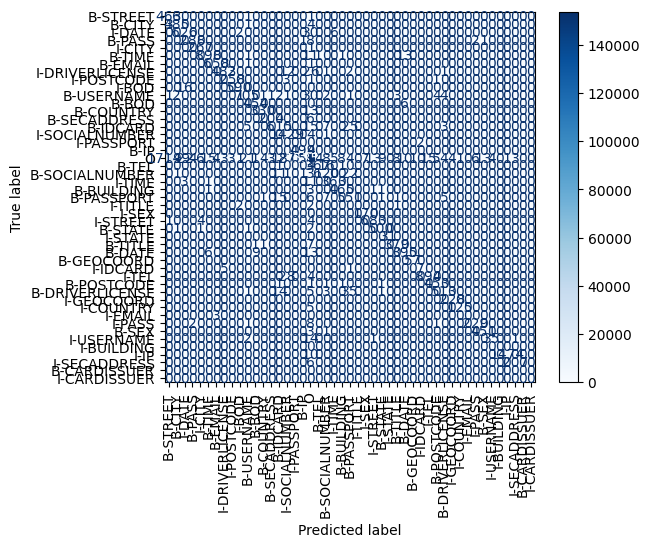

Validation Precision: 0.3676, Recall: 0.9571, F1: 0.5312, Accuracy: 0.9049
New best model saved.


100it [01:00,  1.53it/s]

Epoch 2, step 100: loss = 0.4069


200it [02:06,  1.72it/s]

Epoch 2, step 200: loss = 0.4107


300it [03:03,  1.73it/s]

Epoch 2, step 300: loss = 0.4745


400it [04:09,  1.75it/s]

Epoch 2, step 400: loss = 0.3412


500it [05:15,  1.13it/s]

Epoch 2, step 500: loss = 0.3442


600it [06:17,  1.77it/s]

Epoch 2, step 600: loss = 0.3537


700it [07:17,  1.06it/s]

Epoch 2, step 700: loss = 0.3566


800it [08:28,  1.79it/s]

Epoch 2, step 800: loss = 0.2299


900it [09:36,  1.68it/s]

Epoch 2, step 900: loss = 0.3827


1000it [10:45,  1.62it/s]

Epoch 2, step 1000: loss = 0.3827


1100it [11:42,  1.98it/s]

Epoch 2, step 1100: loss = 0.2207


1200it [12:46,  1.63it/s]

Epoch 2, step 1200: loss = 0.3805


1300it [13:43,  1.48it/s]

Epoch 2, step 1300: loss = 0.3344


1400it [16:16,  1.51s/it]

Epoch 2, step 1400: loss = 0.3750


1500it [18:07,  1.13it/s]

Epoch 2, step 1500: loss = 0.4367


1600it [20:29,  1.59s/it]

Epoch 2, step 1600: loss = 0.3657


1700it [22:52,  1.38s/it]

Epoch 2, step 1700: loss = 0.3497


1800it [25:16,  1.41s/it]

Epoch 2, step 1800: loss = 0.2781


1900it [26:40,  1.08it/s]

Epoch 2, step 1900: loss = 0.3398


2000it [28:02,  1.78it/s]

Epoch 2, step 2000: loss = 0.4955


2100it [29:14,  1.56it/s]

Epoch 2, step 2100: loss = 0.4901


2200it [30:18,  1.77it/s]

Epoch 2, step 2200: loss = 0.3146


2300it [31:16,  1.62it/s]

Epoch 2, step 2300: loss = 0.3987


2332it [31:39,  1.23it/s]


Epoch 2 completed. Average training loss: 0.3594


100%|██████████| 66/66 [02:31<00:00,  2.29s/it]


               precision    recall  f1-score   support

          BOD       0.96      0.98      0.97       460
     BUILDING       0.98      0.97      0.98       471
         CITY       0.96      0.97      0.97       493
      COUNTRY       0.98      0.95      0.96       343
         DATE       0.95      0.92      0.93       423
DRIVERLICENSE       0.91      0.92      0.92       572
        EMAIL       0.99      0.99      0.99       660
     GEOCOORD       0.95      1.00      0.97        57
       IDCARD       0.91      0.86      0.89       670
           IP       0.98      0.96      0.97       503
         PASS       0.86      0.91      0.89       300
     PASSPORT       0.87      0.91      0.89       587
     POSTCODE       0.97      0.98      0.97       458
   SECADDRESS       0.97      0.97      0.97       210
          SEX       0.97      0.99      0.98       455
 SOCIALNUMBER       0.90      0.95      0.92       660
        STATE       0.99      0.98      0.99       505
       ST

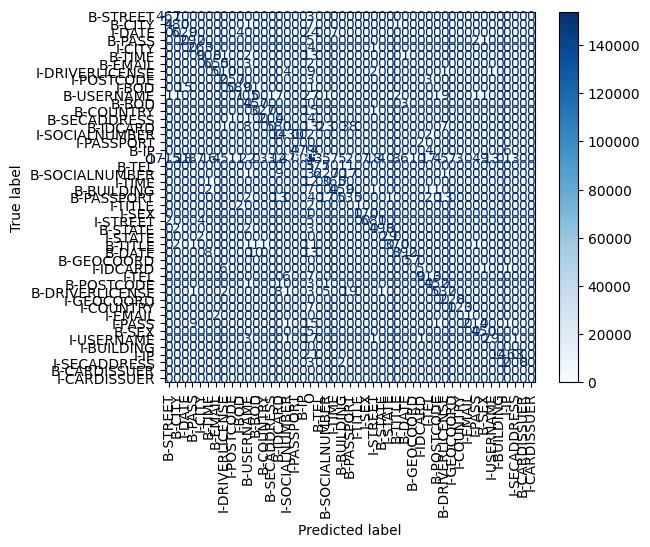

Validation Precision: 0.3661, Recall: 0.9522, F1: 0.5289, Accuracy: 0.9048
No improvement in F1. Patience: 1/2


100it [01:04,  1.95it/s]

Epoch 3, step 100: loss = 0.2960


116it [01:15,  1.54it/s]


KeyboardInterrupt: 

In [ ]:
# Initialize model and move to GPU if available
train_encodings = aux.json_to_Dataset_ensemble("datasets/ensemble_train.json")
val_encodings = aux.json_to_Dataset_ensemble("datasets/ensemble_val.json")

train_loader = DataLoader(train_encodings, batch_size=8, shuffle=True, collate_fn=collate_batch)
dev_loader = DataLoader(val_encodings, batch_size=32, shuffle=True, collate_fn=collate_batch)


model = CubeBert("models/distilbert1", "models/albert1", freeze_backbones=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare optimizer (all parameters of both sub-models are included)
optimizer = AdamW([model.alpha_logits], lr=1e-2)

num_epochs = 20  # total training budget
patience = 2
best_f1 = 0.0
patience_counter = 0

for epoch in range(1, num_epochs+1):
    model.train()  # set model to training mode
    total_loss = 0.0
    for step, batch in tqdm(enumerate(train_loader, start=1)):
        # Move batch data to device
        input_ids_distil = batch["distilbert_inputids"].to(device)
        attention_mask_distil = batch["distilbert_attention_masks"].to(device)
        input_ids_albert = batch["albert_inputids"].to(device)
        attention_mask_albert = batch["albert_attention_masks"].to(device)
        # For training, we can use the subword-aligned labels from one model or the word-level labels.
        # Here we'll use the word-level labels for loss, which our model expects as `labels`.
        labels = batch["spacy_labels"].to(device)
        # Forward pass through the ensemble model
        outputs = model(input_ids_distil=input_ids_distil,
                        attention_mask_distil=attention_mask_distil,
                        input_ids_albert=input_ids_albert,
                        attention_mask_albert=attention_mask_albert,
                        distil_word_ids=batch["distilbert_wordids"],
                        albert_word_ids=batch["albert_wordids"],
                        labels=labels)
        loss = outputs["loss"]
        total_loss += loss.item()
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # (Optional) print loss every N steps for monitoring
        if step % 100 == 0:
            print(f"Epoch {epoch}, step {step}: loss = {loss.item():.4f}")

    avg_loss = total_loss / len(train_loader)
    print(f"Epoch {epoch} completed. Average training loss: {avg_loss:.4f}")

    # Evaluate on validation set
    eval_metrics = evaluate_model(model, dev_loader, device=device)
    f1 = eval_metrics['f1']

    print(f"Validation Precision: {eval_metrics['precision']:.4f}, Recall: {eval_metrics['recall']:.4f}, "
          f"F1: {f1:.4f}, Accuracy: {eval_metrics['accuracy']:.4f}")
    
    alpha_values = torch.sigmoid(model.alpha_logits).detach().cpu().numpy()
    for i, a in enumerate(alpha_values):
        print(f"Class {id2label[i]}: alpha = {a:.2f}")

    # Early stopping check
    if f1 > best_f1:
        best_f1 = f1
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pt")
        print("New best model saved.")
    else:
        patience_counter += 1
        print(f"No improvement in F1. Patience: {patience_counter}/{patience}")
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break
